In [46]:
import os, glob, pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [47]:
MODEL_PATH   = "./modelo_20250523_0212_testAcc0.76.h5"
IMG_SIZE     = (224, 224)                        
CLASS_NAMES  = [                                 #
    "argentine-ants",
    "black-crazy-ants",
    "fire-ants",
    "leafcutter-ants",
    "trap-jaw-ants",
    "weaver-ants",
    "yellow-crazy-ants"
]

In [48]:
NUM_CLASSES  = len(CLASS_NAMES)
TEST_DIR     = pathlib.Path("test_images")

In [49]:
model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 256)     147712    
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 256)     0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 256)     590080    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       5

In [50]:
def load_preprocess(path: pathlib.Path) -> np.ndarray:
    """
    Returns float32 tensor in range [0,1] shaped (H,W,3)
    """
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)
    arr = np.asarray(img, dtype=np.float32) / 255.0   # same rescale used in training
    return arr

In [51]:
# Cargar rutas Y SALTAR archivos no‑imagen
valid_ext = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

image_paths, images, file_names = [], [], []

for p in TEST_DIR.rglob("*"):
    # descarta alternate streams o archivos sin extensión conocida
    if p.suffix.lower() not in valid_ext or not p.is_file():
        continue
    try:
        img = load_preprocess(p)      # intenta abrir y normalizar
        images.append(img)
        image_paths.append(p)
        file_names.append(p.name)
    except Exception as e:
        print(f"⚠️  Skipping {p.name}: {e}")

if not images:
    raise RuntimeError("No valid images were loaded.")

images = np.stack(images)
print(f"Loaded {len(images)} images.")

Loaded 5 images.


In [52]:
preds = model.predict(images, batch_size=32, verbose=1)
print("Salidas del modelo:", preds.shape)
print("Longitud CLASS_NAMES:", len(CLASS_NAMES))


1/1 [==============================] - 0s 404ms/step
Salidas del modelo: (5, 7)
Longitud CLASS_NAMES: 7


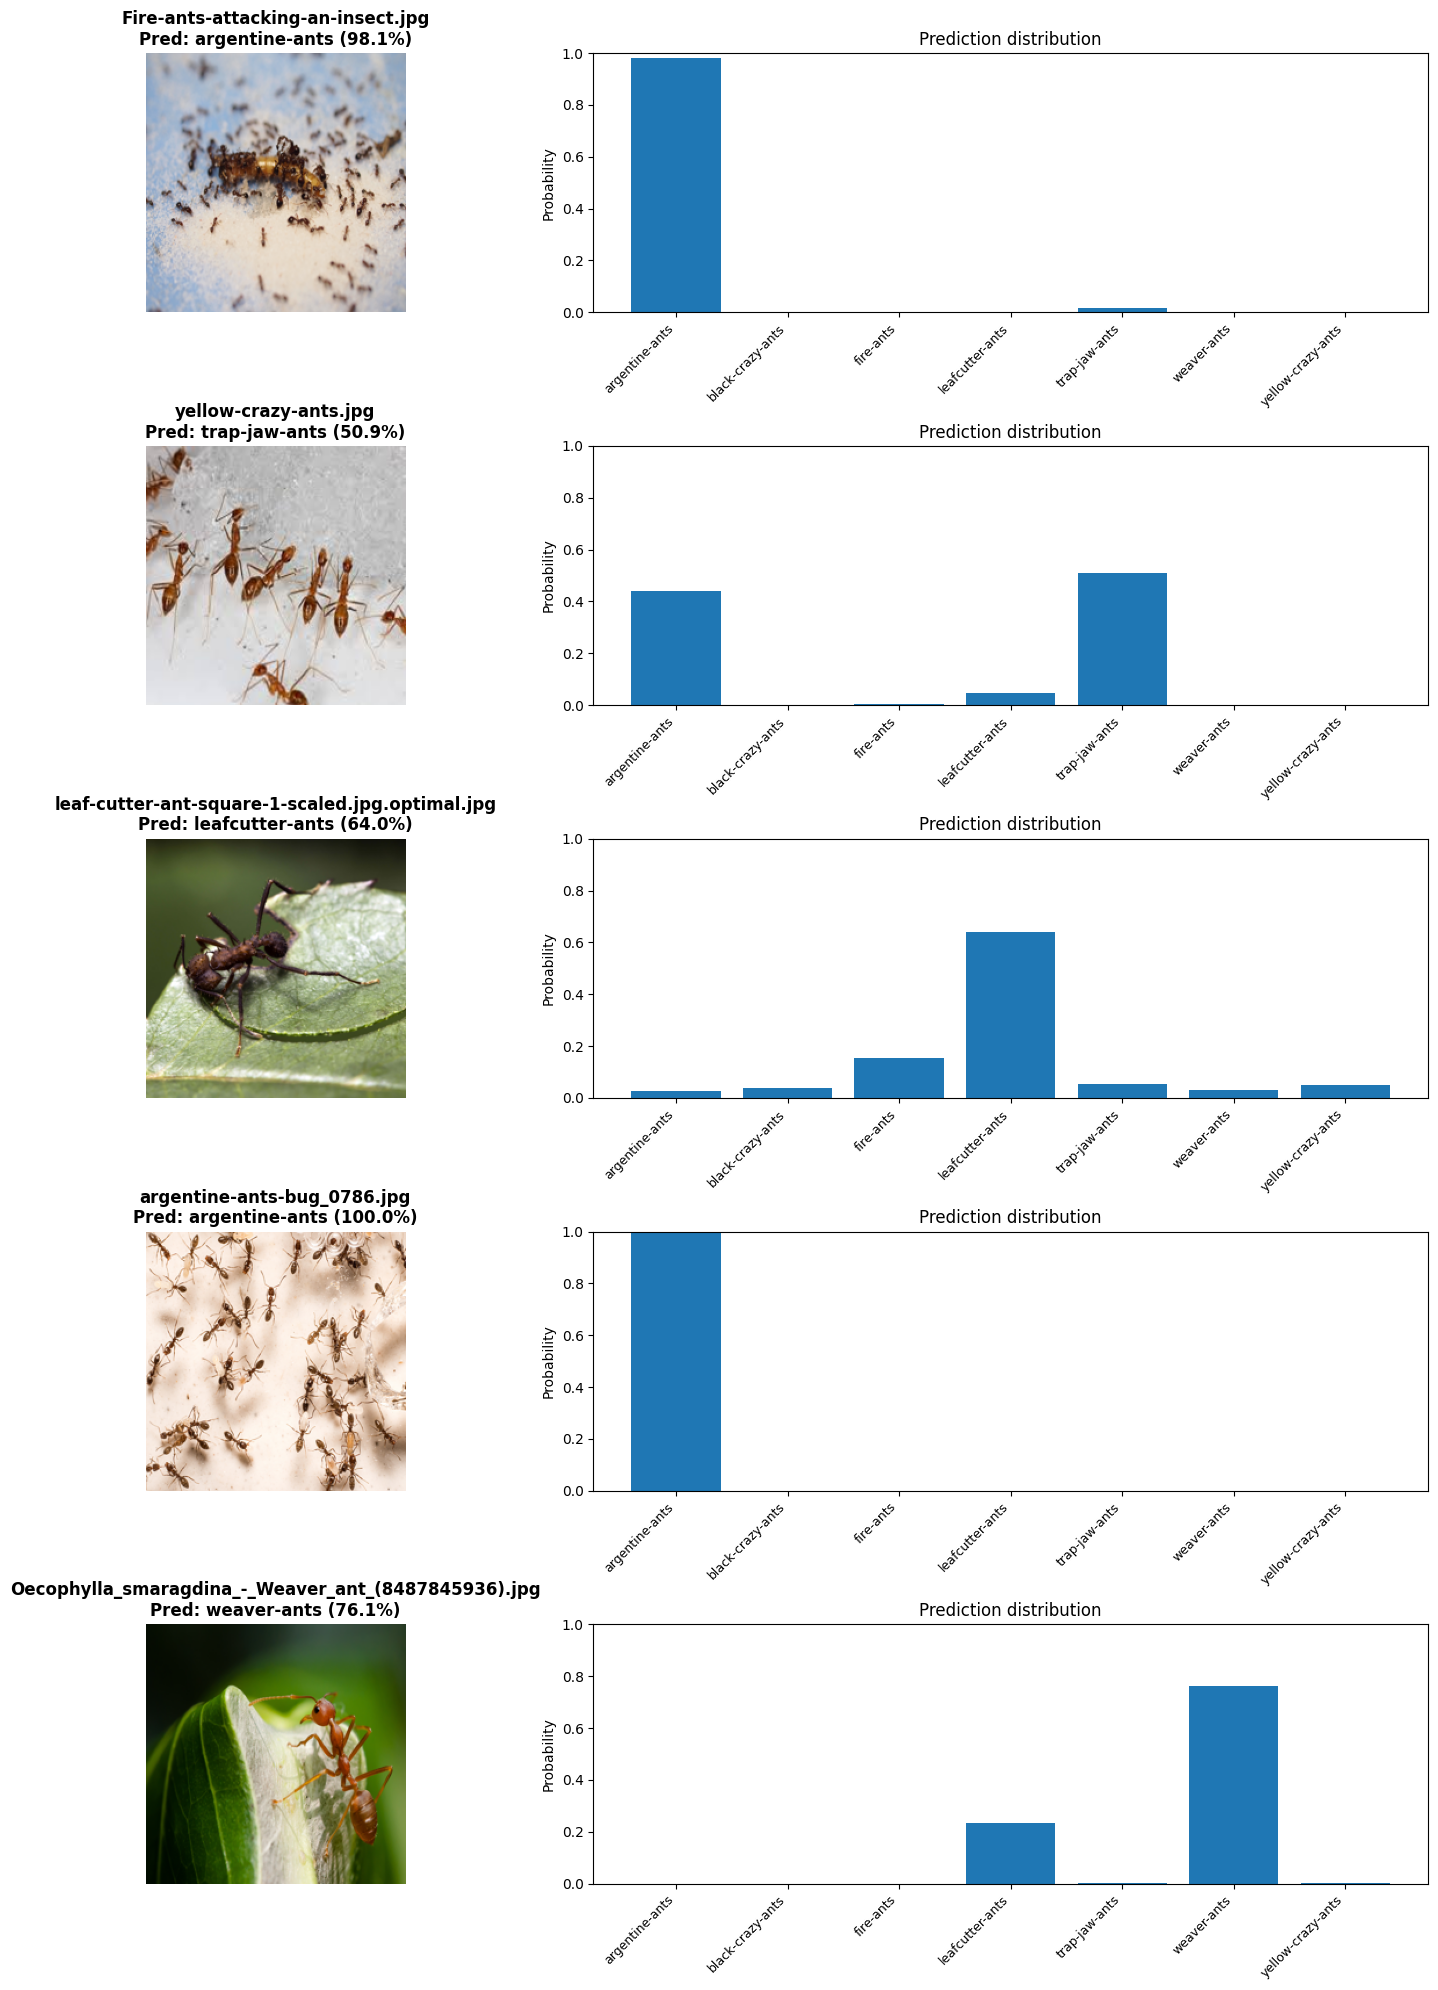

In [53]:
import math
import matplotlib.pyplot as plt
import numpy as np

ROWS = len(images)
if ROWS == 0:
    raise RuntimeError("No hay imágenes cargadas – nada que graficar.")

rows_to_plot = ROWS
    
fig, axes = plt.subplots(
    rows_to_plot, 2,
    figsize=(16, 4 * rows_to_plot),
    squeeze=False 
)
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i in range(rows_to_plot):
    img        = images[i]
    pred_vec   = preds[i]
    fname      = file_names[i]
    
    pred_idx   = np.argmax(pred_vec)
    pred_lbl   = CLASS_NAMES[pred_idx]
    confidence = pred_vec[pred_idx]

    ax_img = axes[i, 0]
    ax_img.imshow((img * 255).astype("uint8"))
    ax_img.axis("off")
    ax_img.set_title(
        f"{fname}\nPred: {pred_lbl} ({confidence:.1%})",
        fontweight="bold",
        fontsize=12
    )

    ax_bar = axes[i, 1]
    ax_bar.bar(range(NUM_CLASSES), pred_vec, color="tab:blue")
    ax_bar.set_xticks(range(NUM_CLASSES))
    ax_bar.set_xticklabels(CLASS_NAMES, rotation=45, ha="right", fontsize=9)
    ax_bar.set_ylim(0, 1)
    ax_bar.set_ylabel("Probability")
    ax_bar.set_title("Prediction distribution")

plt.tight_layout()
plt.show()
